In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from functools import partial
from scipy.optimize import minimize
import time
import random
import multiprocessing
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

## 1. The differential equation-based diffusion model (Bass model)

In [2]:
def dem(params):
    '''
    differential equation-based model
    '''
    p, q, m, T = params
    t_list = np.arange(1, T + 1)
    a = 1 - np.exp(-(p + q) * t_list)
    b = 1 + q / p * np.exp(-(p + q) * t_list)
    diffu_cont = m * a / b
    adopt_cont = np.array(
        [diffu_cont[i] if i == 0 else diffu_cont[i] - diffu_cont[i - 1] for i in range(T)]
    )
    return adopt_cont

In [3]:
def calcu_mse(params, s):  # mean squared error
    '''
    calculate the mean squared error between the output of dem and empirical data
    '''
    p, q, m = params
    a = dem([p, q, m, len(s)])
    sse = np.sum(np.square(s - a))
    return np.sqrt(sse) / len(s)  # 均方误

In [4]:
def calcu_r2(estimates, s):
    '''
    calculate the r2 for the fit
    '''
    s_hat = dem(params=(*estimates, len(s)))
    tse = np.sum(np.square(s - s_hat))
    mean_y = np.mean(s)
    ssl = np.sum(np.square(s - mean_y))
    R_2 = (ssl - tse) / ssl
    return round(R_2, 5)

In [5]:
def fit_dem(s):
    '''
    fit empirical data with dem
    '''
    mse = partial(calcu_mse, s=s)  # fix the parameter s
    candidate_sols = []
    for i in range(10):  # repeate the estimation to increate the probability of getting the optimal estimates
        p0, q0, m0 = 0.01 * np.random.rand(), 0.4 * np.random.rand(), 2*np.sum(s)  # randomly set the initial values
        try:
            res = minimize(mse, (p0, q0, m0), method='nelder-mead', options={'xatol': 1e-6})
            candidate_sols.append([res.fun, res.x])
        except Exception as e:
            print(e)

    func_value, estimates = sorted(candidate_sols, key=lambda x: x[0])[0]
    r2 = calcu_r2(estimates, s)
    return r2, estimates

In [6]:
data_set = {
    "room air conditioners": (
        np.arange(1949, 1962),
        [96, 195, 238, 380, 1045, 1230, 1267, 1828, 1586, 1673, 1800, 1580, 1500],
    ),
    "color televisions": (np.arange(1963, 1971), [747, 1480, 2646, 5118, 5777, 5982, 5962, 4631]),
    "clothers dryers": (
        np.arange(1949, 1962),
        [106, 319, 492, 635, 737, 890, 1397, 1523, 1294, 1240, 1425, 1260, 1236],
    ),
    "ultrasound": (np.arange(1965, 1979), [5, 3, 2, 5, 7, 12, 6, 16, 16, 28, 28, 21, 13, 6]),
    "mammography": (np.arange(1965, 1979), [2, 2, 2, 3, 4, 9, 7, 16, 23, 24, 15, 6, 5, 1]),
    "foreign language": (
        np.arange(1952, 1964),
        [1.25, 0.77, 0.86, 0.48, 1.34, 3.56, 3.36, 6.24, 5.95, 6.24, 4.89, 0.25],
    ),
    "accelerated program": (
        np.arange(1952, 1964),
        [0.67, 0.48, 2.11, 0.29, 2.59, 2.21, 16.80, 11.04, 14.40, 6.43, 6.15, 1.15],
    ),
}

In [8]:
year, sales = data_set["color televisions"]  # empirical data
r2, estimates = fit_dem(sales)
print(f"r2: {r2}\nestimates: p={estimates[0]:.5f}, q={estimates[1]:.5f}, m={estimates[2]:.1f},")

r2: 0.9695
estimates: p=0.01847, q=0.61586, m=39658.6,


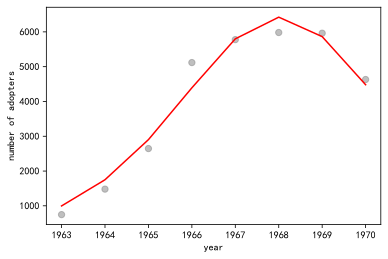

In [10]:
plt.xlabel("year")
plt.ylabel("number of adopters")
plt.plot(year, dem([*estimates, len(sales)]), 'r-')
plt.scatter(year, sales, c='grey', alpha=0.5, s=40)

## 2. Agent-based diffusion model（ABM）

In [11]:
class Diffuse:  # 默认网络结构为节点数量为10000，边为30000的随机网络
    def __init__(self, p, q, alpha=0, sigma=0, g=nx.gnm_random_graph(10000, 30000), num_runs=40, multi_proc=True):
        '''
        p: coefficient of external influence
        q: coefficient of internal influence
        alpha: strength of neighborhood effects
        sigma: individual heterogeneity
        g: network
        num_runs: number of steps for simulation
        '''
        self.g = g.to_directed() if not nx.is_directed(g) else g
        self.nodes_array = np.array(self.g)
        self.num_runs = num_runs
        self.multi_proc = multi_proc
        self.alpha = alpha
        self.sigma = sigma
        for i in self.g:
            self.g.nodes[i]['prede'] = list(self.g.predecessors(i))
            self.g.nodes[i]['num_prede'] = len(self.g.nodes[i]['prede'])
            self.g.nodes[i]['p'] = p*(1 + self.sigma*np.random.randn())
            self.g.nodes[i]['q'] = q*(1 + self.sigma*np.random.randn())
                 
    def decide(self, i):
        '''
        agent i makes innovation decision
        '''
        num_adopt_prede = np.sum([self.g.nodes[k]['state'] for k in self.g.nodes[i]['prede']])
        if self.g.nodes[i]['num_prede']:  # check whether agent i has precedessors or not
            mi = num_adopt_prede/(self.g.nodes[i]['num_prede']**self.alpha)
        else:
            mi = 0
        prob = 1 - (1 - self.g.nodes[i]['p'])*(1 - self.g.nodes[i]['q'])**mi
        return prob > random.random()  # the probability of this inequation takes the value of True is equal to prob

    def update(self, non_node_array):
        '''
        non-adopted agents update states
        '''
        len_nodes = len(non_node_array)  # amount of non-adopted agents
        state_array = np.zeros(len_nodes, dtype=bool)
        for i in range(len_nodes):
            node = non_node_array[i]
            if self.decide(node):
                self.g.nodes[node]['state'] = True  # update node's state
                state_array[i] = True
        return np.sum(state_array), non_node_array[state_array == False]

    def single_diffuse(self):
        '''
        a single diffusion process
        '''
        for i in self.g:  # initialize the state of agents
            self.g.nodes[i]['state'] = False
        non_node_array = self.nodes_array[:]  # array of non-adopted nodes
        num_of_adopt = []  # number of adopters for each step
        for i in range(self.num_runs):
            num, non_node_array = self.update(non_node_array)
            num_of_adopt.append(num)

        return num_of_adopt
    
    def repete_diffuse(self, repetes=10):  # multiple runs of the ABM
        '''
        perform multiple diffusion processes for a parameter configuration
        '''
        if self.multi_proc:
            if repetes < 5:
                pool = multiprocessing.Pool(processes=repetes)
            else:
                pool = multiprocessing.Pool(processes=5)
            proc = []
            for i in range(repetes):
                proc.append(pool.apply_async(self.single_diffuse))

            pool.close()
            pool.join()
            return [res.get() for res in proc]
        else:
            return [self.single_diffuse() for i in range(repetes)]

In [12]:
diffuse = Diffuse(p=0.001, q=0.1)
s_diff = diffuse.repete_diffuse(repetes=5)

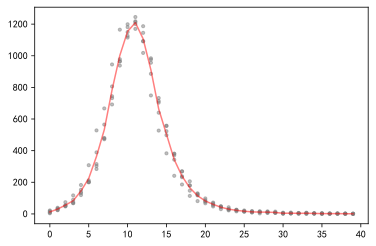

In [13]:
for s in s_diff:
    plt.scatter(np.arange(len(s)), s, color='grey', s=10, alpha=0.5)
    
plt.plot(np.arange(len(s)), np.mean(s_diff, axis=0), 'r-', lw=1.5, alpha=0.5)

In [14]:
gen_para = Gen_para(g=nx.gnm_random_graph(10000, 20000))

NameError: name 'Gen_para' is not defined

In [ ]:
t1 = time.perf_counter()
print("======start======")
generated_params_range = gen_para.identify_range()
print(f"Time elapsed {time.perf_counter() - t1:.4f}s")
print("======end======")

In [ ]:
p_range, q_range = generated_params_range["p_range"], generated_params_range["q_range"]
parameters = gen_para.generate_sample(p_range, q_range)

In [ ]:
p_range, q_range

In [ ]:
client = MongoClient('localhost', 27017)
db = client.abmDiffusion
prj = db.sparsity

txt_cont = ['gnm_random_graph(10000,1000)', 'gnm_random_graph(10000,2000)',
    'gnm_random_graph(10000,4000)', 'gnm_random_graph(10000,6000)',
    'gnm_random_graph(10000,8000)', 'gnm_random_graph(10000,10000)', 
    'gnm_random_graph(10000,20000)']

g_cont = [eval('nx.' + g) for g in txt_cont]
bound_dict = {}
for j, g in enumerate(g_cont):
    t1 = time.perf_counter()
    print(j+1, txt_cont[j])
    p_cont = (0.0003, 0.02)  
    q_cont = (0.076*3.0/(j + 4), 0.12*3.0/(j + 4))  # 小心设置
    delta = (0.0001, 0.001)
    ger_samp = Gen_para(g=g, p_cont=p_cont, q_cont=q_cont, delta=delta)
    bound = ger_samp.identify_range()
    prj.insert_one({"_id": txt_cont[j], "param_boundary": bound})
    print(f'  time: {time.perf_counter() - t1:.2f}s')

## 3. The proposed procedure for calibrating the ABM by using the DEM

In [15]:
class calibrate_ABM:
    num_conds = 2  # the number of points to construct grids

    def __init__(self, s, intv_p=0.0005, intv_q=0.005, G=nx.gnm_random_graph(10000, 30000), multi_proc=True):
        self.s = s  # the empirical diffusion data
        self.s_len = len(s)  # the number of points of the data
        self.intv_p = intv_p  # the increment for p each move
        self.intv_q = intv_q  # the increment for q each move
        self.G = G  # the network on which the ABM builds
        self.multi_proc = multi_proc
        self.k = 2*nx.number_of_edges(self.G) / nx.number_of_nodes(self.G)  # the average degree of G

    def r2(self, f_act):
        '''
        calculate the r2 of fitting between s and f_act
        '''
        f_act = np.array(f_act)
        tse = np.sum(np.square(self.s - f_act))
        mean_y = np.mean(self.s)
        ssl = np.sum(np.square(self.s - mean_y))
        return (ssl - tse)/ssl

    def get_M(self, p, q):
        '''
        get the corresponding parameter (m) for a pair of (p, q).
        impementation of equation (11)
        '''
        if p <= 0:
            raise Exception(f"p={p} is less than 0!")
        elif q <= 0:
            raise Exception(f"q={q} is less than 0!")
        else:
            diffu = Diffuse(p, q, g=self.G, num_runs=self.s_len)
            s_estim = diffu.repete_diffuse()
            x = np.mean(s_estim, axis=0)
            a = np.sum(np.square(x)) / np.sum(self.s)  # 除以np.sum(self.s)是为减少a的大小
            b = -2*np.sum(x*self.s) / np.sum(self.s)
            c = np.sum(np.square(self.s)) / np.sum(self.s)
            mse = np.sqrt(sum(self.s) * (4*a*c - b**2) / (4*a*self.s_len))
            sigma = -b/(2*a)
            m = sigma*self.G.number_of_nodes()
            return [mse, p, q, m], list(x*sigma)

    def gener_grid(self, p, q):
        '''
        generate a set of points around the point (p, q)
        implementation of stage 2 (1)
        '''
        p, q = round(p, 5), round(q, 5)
        temp = {(round(p - self.intv_p, 5) if p > self.intv_p else round(p/2, 5), 
                    round(q - self.intv_q, 5) if q > self.intv_q else round(q/2, 5)),
                (round(p, 5),
                    round(q - self.intv_q, 5) if q > self.intv_q else round(q/2, 5)),
                (round(p + self.intv_p, 5),
                    round(q - self.intv_q, 5) if q > self.intv_q else round(q/2, 5)),
                (round(p - self.intv_p, 5) if p > self.intv_p else round(p/2, 5), 
                    round(q, 5)),
                (round(p, 5), round(q, 5)),
                (round(p + self.intv_p, 5), round(q, 5)),
                (round(p - self.intv_p, 5) if p > self.intv_p else round(p/2, 5), 
                    round(q + self.intv_q, 5)),
                (round(p, 5), round(q + self.intv_q, 5)),
                (round(p + self.intv_p, 5), round(q + self.intv_q, 5))
                }
        return temp

    def gener_init_pq(self):
        '''
        Stage (1): generate an initial point for the ABM
        '''
        P0, Q0 = fit_dem(self.s)[1][:2]  # the estimates of the DEM
        # To get a representive result, we choose these points dispersdly.
        # This step can also randomly choose a set of points in a range.
        p_range = np.linspace(0.4*P0, P0, num=3)
        q_range = np.linspace(0.4*Q0/self.k, 1.2*Q0/self.k, num=3)
        to_fit = {}
        params_cont = []
        # Nine pairs of (p, q) for generating ABM diffusion data
        for p in p_range:  
            for q in q_range:
                # generated diffusion data from the ABM
                diffu = Diffuse(p, q, g=self.G, num_runs=self.s_len)
                s_estim = diffu.repete_diffuse()
                s_estim_avr = np.mean(s_estim, axis=0)
                # fit the diffusion data with the DEM
                P, Q = fit_dem(self.s)[1][:2]
                # save the parameters and estimates
                params_cont.append([p, q, P, Q])
        
        # perform the OLS analysis
        to_fit = pd.DataFrame(params_cont, columns=['p', 'q', 'P', 'Q'])
        result_p = smf.ols('p~P+Q-1', data=to_fit).fit()
        result_q = smf.ols('q~P+Q-1', data=to_fit).fit()
        
        # obtain the initial point for the ABM
        p0 = result_p.params['P']*P0 + result_p.params['Q']*Q0
        q0 = result_q.params['P']*P0 + result_q.params['Q']*Q0
        return round(p0, 5), round(q0, 5)

    def solution_search(self, p0, q0):
        '''
        Stage (2): search from the initial point (p0, q0)
        '''
        solution_list = []
        pq_set = self.gener_grid(p0, q0)  # generate a set of points around (p0, q0)
        pq_trace = [pq_set.copy()]  # the list to keep the search history
        for p, q in pq_set:
            try:
                solution = self.get_M(p, q)
                solution_list.append(solution)
            except Exception:
                print(f"Error, omit searching p:{p}, q:{q}！")

        best_solution = sorted(solution_list)[:self.num_conds]  # chooose the best num_conds candidate solutions
        condidate_points = [(z[0][1], z[0][2]) for z in best_solution]  # extract the corresponding (p, q)
        his_cond = [condidate_points, ]  # the slist to keep the history of the best solution for each run
        i = 0
        while True:
            i += 1
            pq_set2 = set()
            for z in condidate_points:  # construct grids around the condidate points
                temp = self.gener_grid(z[0], z[1])
                pq_set2.update(temp)

            new_points = pq_set2 - pq_set  # exclude the (p, q) already in the set pd_set
            print(f"{i} iteration, newly added points for evaluation:{len(new_points)}")
            if len(new_points) == 0:
                break
            else:
                pq_trace.append(new_points)
                for y in new_points:
                    try:
                        solution = self.get_M(y[0], y[1])
                        solution_list.append(solution)
                    except Exception:
                        print(f"Error, omit search (p:{p}, q:{q})！")
                
                # obtain the solution with the least mse
                best_solution = sorted(solution_list, key=lambda x: x[0][0])[: self.num_conds]
                condidate_points = [(z[0][1], z[0][2]) for z in best_solution]
                his_cond.append(condidate_points)
                opt_solution = best_solution[0]  # [mse, p, q, m], diffusion data
                opt_curve = opt_solution[1]  # diffusion data
                pq_set.update(new_points)

        R2 = self.r2(opt_curve)  # calculate the r2 between self.s and opt_curve
        search_steps = len(pq_set)  # number of points evaluated during the searching process
        result = {'params': opt_solution[0][1:],  # [p, q, m]
                  'fitness': R2,
                  'best_curve': opt_curve,  # the best fit curve
                  'num_nodes': search_steps,
                  'path': pq_trace,
                  'his_cond': his_cond,
                  'his_data': solution_list}
        return result

In [25]:
sales = data_set["color televisions"][1]  # empirical data
year = data_set["color televisions"][0]
cal_abm = calibrate_ABM(sales)

In [26]:
# stage 1
t1 = time.perf_counter()
p0, q0 = cal_abm.gener_init_pq()
print(f"Time elasped: {time.perf_counter() - t1:.2f} secondes")
print(f"The initial point: p0={p0}, q0={q0}")

Time elasped: 46.06 secondes
The initial point: p0=0.01368, q0=0.07221


In [27]:
# stage 2
t1 = time.perf_counter()
res = cal_abm.solution_search(p0, q0)
print(f"Time elasped: {time.perf_counter() - t1:.2f} secondes")
r2 = res["fitness"]
print(f"R2={r2:.4f}")

1 iteration, newly added points for evaluation:3
2 iteration, newly added points for evaluation:9
3 iteration, newly added points for evaluation:6
4 iteration, newly added points for evaluation:7
5 iteration, newly added points for evaluation:6
6 iteration, newly added points for evaluation:6
7 iteration, newly added points for evaluation:7
8 iteration, newly added points for evaluation:6
9 iteration, newly added points for evaluation:5
10 iteration, newly added points for evaluation:0
Time elasped: 285.22 secondes
R2=0.9723


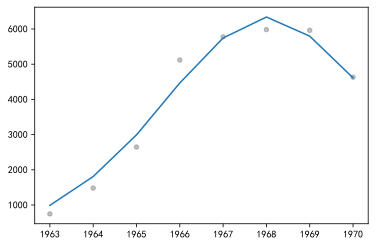

In [28]:
plt.plot(year, res["best_curve"][:len(sales)])
plt.scatter(year, sales, color="grey", alpha=0.5, s=20)